# Imports Required for Lab

In [2]:
# Standard Libararies
import os
import random 
import textwrap
import numpy as np
import pandas as pd

# Progress Bars
from tqdm import tqdm

# Neueral Networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

# Plotting and Image Processing
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize

# Memory Optimization
from joblib import dump
from joblib import load
import gc

In [3]:
print("Using torch", torch.__version__)

Using torch 2.4.0.post101


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

mps_avail = torch.backends.mps.is_available()
print(f"Is the Mac MPS (GPU for Mac) available? {mps_avail}")

if(gpu_avail):
    device = "cuda"
elif(mps_avail):
    device = "mps"
else:
    device = "cpu"

Is the GPU available? False
Is the Mac MPS (GPU for Mac) available? True


# Question 5

In [5]:
training_classifications = 'training_classifications.csv'
training_classifications_df = pd.read_csv('training_classifications.csv')
training_classifications_df

GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0        100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1        100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2        100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3        100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4        100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
61573    999948  0.510379  0.489621  0.000000  0.059207  0.430414  0.000000   
61574    999950  0.901216  0.098784  0.000000  0.000000  0.098784  0.000000   
61575    999958  0.202841  0.777376  0.019783  0.116962  0.660414  0.067245   
61576    999964  0.091000  0.909000  0.000000  0.045450  0.863550  0.022452   
61577    999967  0.767000  0.140000  0.093000  0.000000  0.140000  0.000000   

       Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0      0.578401  0.418398  0.198455  ...  0.000000   0.279952   0.138445   
1      0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2      0.177352  0.000000  0.177352  ...  0.000000   0.000000   0.000000   
3      0.129071  0.189098  0.049466  ...  0.000000   0.094549   0.000000   
4      0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   
...         ...       ...       ...  ...       ...        ...        ...   
61573  0.430414  0.226257  0.204157  ...  0.000000   0.226257   0.000000   
61574  0.098784  0.000000  0.098784  ...  0.000000   0.000000   0.000000   
61575  0.593168  0.140022  0.520391  ...  0.000000   0.000000   0.090673   
61576  0.841098  0.795330  0.068220  ...  0.000000   0.068398   0.318132   
61577  0.140000  0.023380  0.116620  ...  0.000000   0.023380   0.000000   

       Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  \
0       0.000000   0.000000   0.092886   0.000000   0.000000        0.0   
1       0.459950   0.000000   0.591328   0.000000   0.000000        0.0   
2       0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
3       0.094549   0.189098   0.000000   0.000000   0.000000        0.0   
4       0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
...          ...        ...        ...        ...        ...        ...   
61573   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
61574   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
61575   0.049349   0.000000   0.067726   0.000000   0.000000        0.0   
61576   0.408799   0.227464   0.408799   0.090668   0.023065        0.0   
61577   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   

       Class11.6  
0       0.325512  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.000000  
...          ...  
61573   0.226257  
61574   0.000000  
61575   0.072296  
61576   0.045334  
61577   0.023380  

[61578 rows x 38 columns]

**How many images are in the training set?**

There are 61578 images in the training set

In [6]:
os.listdir('training_images')[0]

'873932.jpg'

In [7]:
# Function to add white border around plots for ease of visibility
def add_subplot_border(ax, width=1, color=None):

    fig = ax.get_figure()

    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle(
        (x0, y0), x1-x0, y1-y0,
        color=color,
        transform=ax.transAxes,
        zorder=-1,
        lw=2*width+1,
        fill=None,
    )
    fig.patches.append(rect)

In [8]:
# Use dark background
plt.style.use('dark_background')

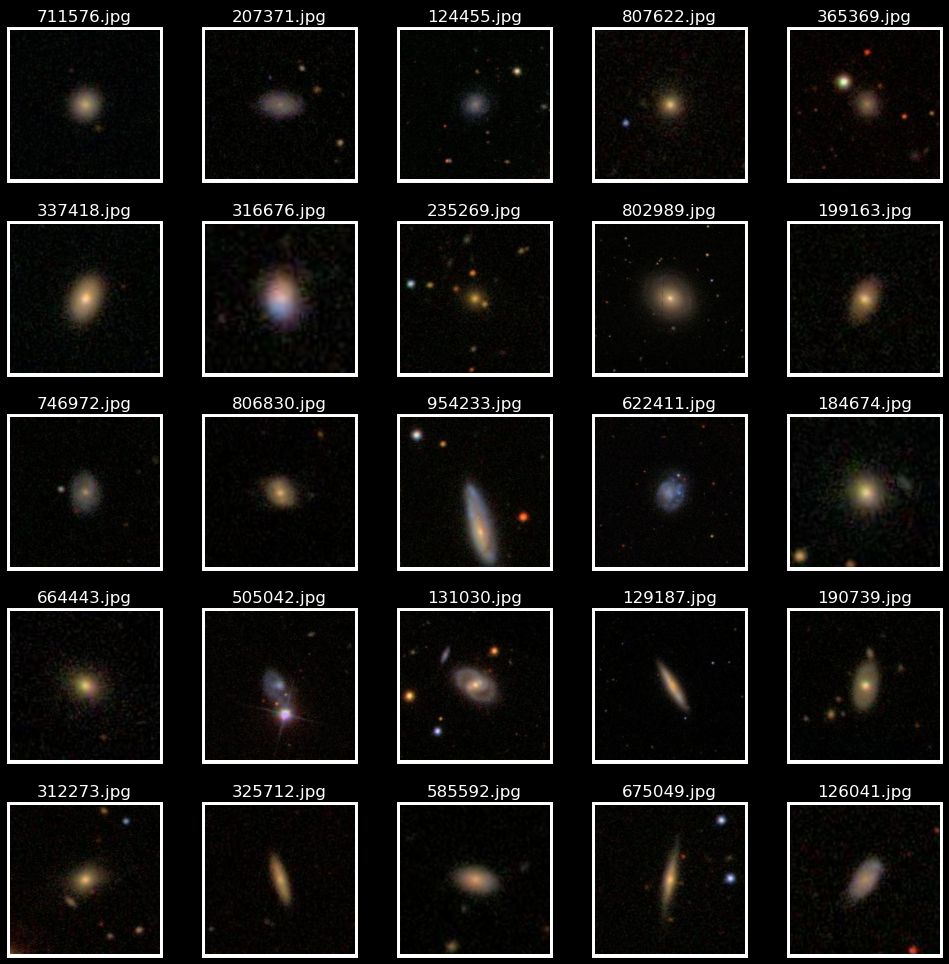

In [9]:
# Plot the 25 randomly selected images
random.seed(42)

root = "../../lab_notebooks/Lab 3/training_images"
cols, rows = 5, 5

# Make a new figure and define dark themed style
figure = plt.figure(figsize=(12,12))

# Create plotted filenames array for later
plotted_images = []

for i in range(1, cols * rows + 1):
    rand_idx = random.randint(0, 61577)
    ax = figure.add_subplot(rows, cols, i)
    filename = f"{training_classifications_df['GalaxyID'].iloc[rand_idx]}.jpg"
    img = plt.imread(os.path.join(root, filename))
    plotted_images.append(img)
    plt.imshow(img)
    plt.title(f"{filename}")
    plt.axis('off')
    add_subplot_border(ax, width=2, color='white')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [10]:
print(type(img))

<class 'numpy.ndarray'>


In [11]:
print(img.shape[:2])

(424, 424)


**What is their dimension?**

The Image is of dimension 424 x 424 pixels

# Question 6

In [12]:
classification_names = ['GalaxyID',
                        'Amount of Smoothness for a disk',
                        'Signs of features or a disk',
                        'Classified as Star or Artifact',
                        'Disk can be viewed edge-on',
                        'Disk cannot be viewed edge-on',
                        'Bar or feature through centre of galaxy detected',
                        'Bar or feautre through centre of galaxy not detected',
                        'Signs of a spiral arm pattern',
                        'No signs of a spiral arm pattern',
                        'No bulge',
                        'Just noticeable bulge',
                        'Obvious bulge',
                        'Dominant bulge',
                        'Odd features in image',
                        'No odd features in image',
                        'Completely round',
                        'In-between round and cigar',
                        'Cigar-shaped',
                        'Presence of Ring',
                        'Presence of lens or arc',
                        'Disturbed galaxy',
                        'Irregular galaxy',
                        'Presence of other odd features',
                        'Merger galaxies',
                        'Presence of dust lane',
                        'Rounded bulge at centre',
                        'Boxy bulge at centre',
                        'No bulge at centre',
                        'Tight spiral arms',
                        'Medium spiral arms',
                        'Loose spiral arms',
                        '1 spiral arm',
                        '2 spiral arms',
                        '3 spiral arms',
                        '4 spiral arms',
                        'More than 4 spiral arms',
                        'Can\'t tell if any spiral arms exist']

# define variable to store number of lables
num_labels = len(training_classifications_df.dtypes.index.tolist())

print(num_labels)
print(len(classification_names))

38
38


In [13]:
def wrap_title(text, width):
    return "\n".join(textwrap.wrap(text, width=width))

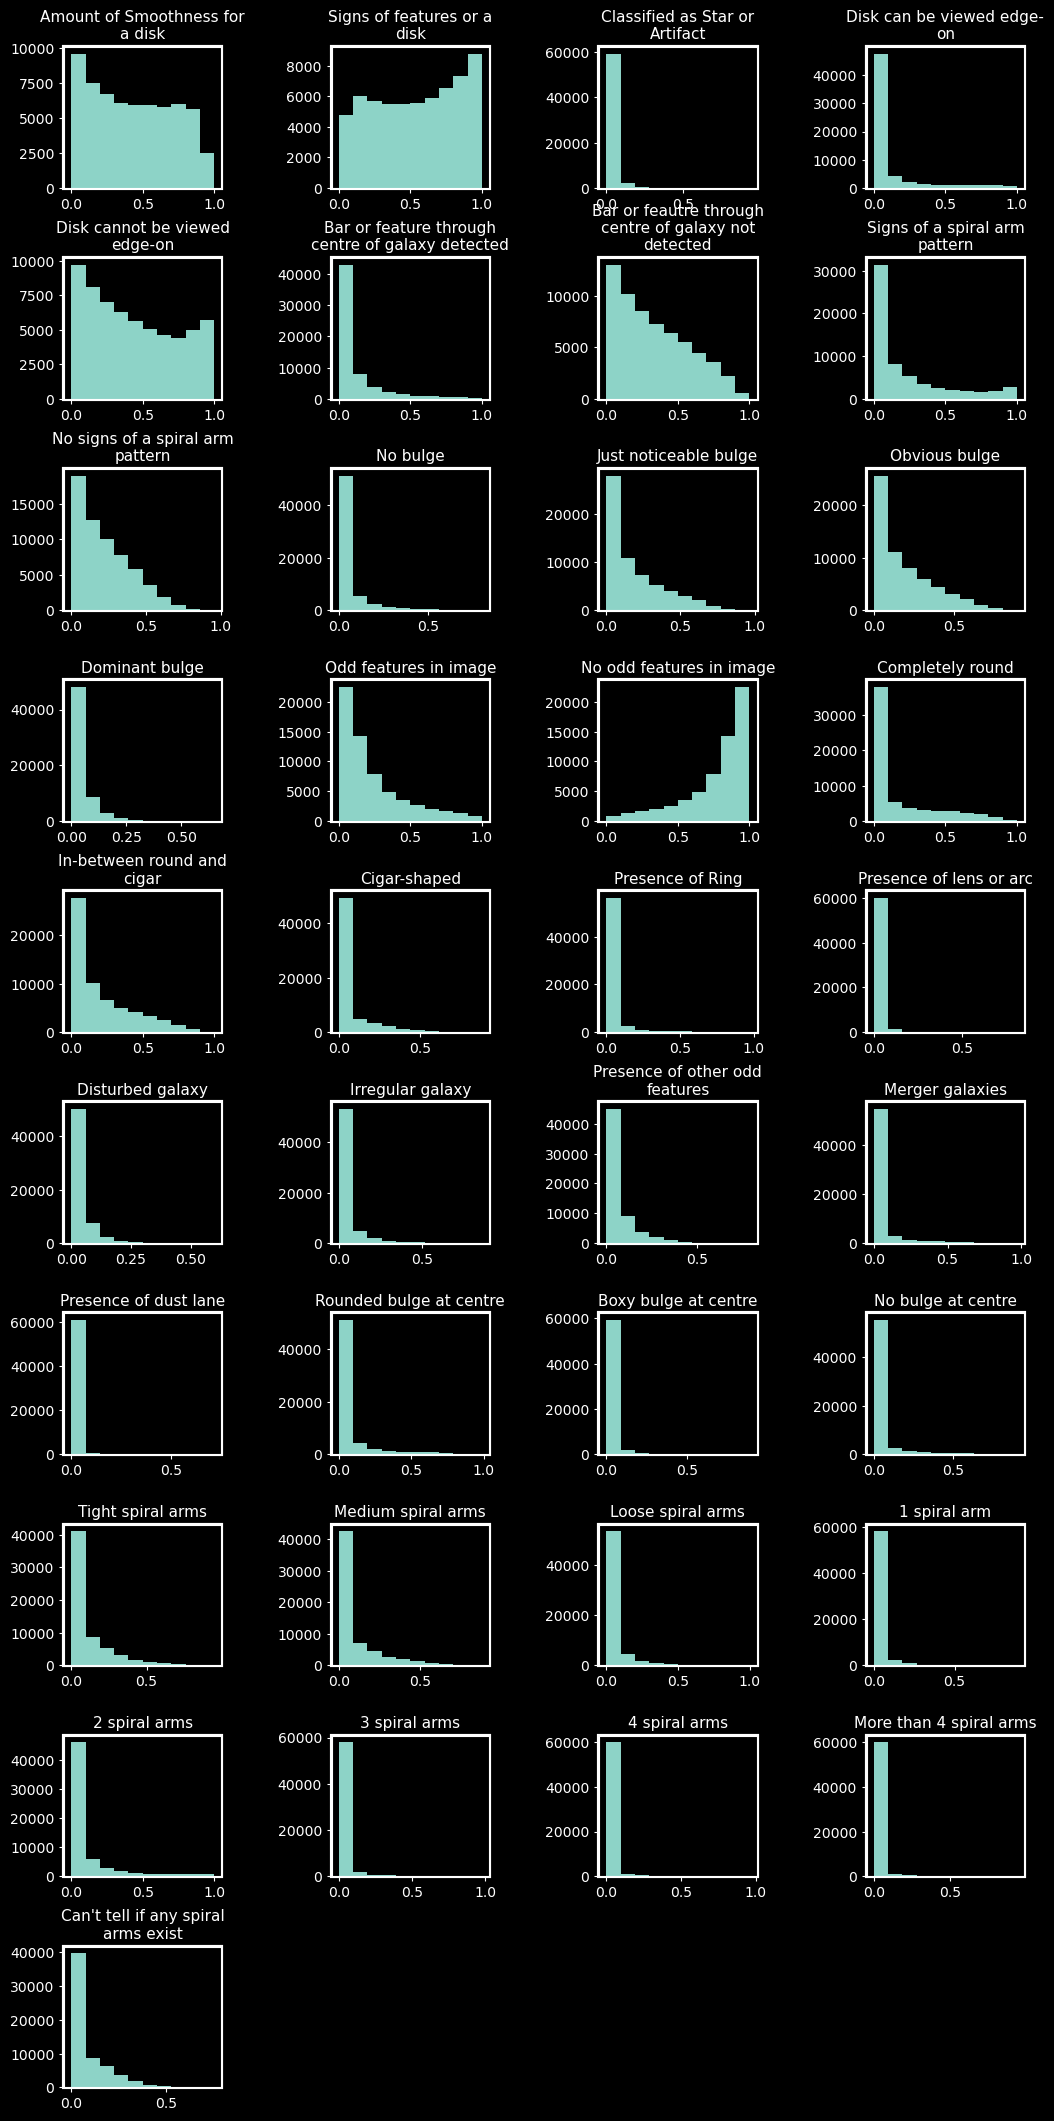

In [17]:
# Make a new figure and define dark themed style
figure = plt.figure(figsize=(12,12))
rows, cols = 10, 4

for i in range(1, len(classification_names)):
    ax = figure.add_subplot(rows, cols, i)
    vals = training_classifications_df.iloc[:, i]
    plt.hist(vals)
    plt.title(wrap_title(classification_names[i], width=25), fontsize=11)
    add_subplot_border(ax, width=1, color='white')

# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=1.7, bottom=0.0, wspace=0.7, hspace=0.5)
plt.show()

**Comment on the distributions. Are any of them multi-modal, or particularly skewed? What does that tell us about that label?**

# Question 7

In [18]:
max_rows = training_classifications_df.idxmax()
maxxed_df = training_classifications_df.loc[max_rows]
maxxed_df

GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
61577    999967  0.767000  0.140000  0.093000  0.000000  0.140000  0.000000   
369      105447  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
56       100859  0.000000  1.000000  0.000000  0.040909  0.959091  0.133534   
17392    356310  0.064853  0.000000  0.935147  0.000000  0.000000  0.000000   
16564    344604  0.000000  1.000000  0.000000  1.000000  0.000000  0.000000   
342      105009  0.000000  1.000000  0.000000  0.000000  1.000000  0.833000   
7163     205541  0.000000  1.000000  0.000000  0.000000  1.000000  1.000000   
5763     185561  0.000000  1.000000  0.000000  0.000000  1.000000  0.000000   
342      105009  0.000000  1.000000  0.000000  0.000000  1.000000  0.833000   
46730    780966  0.000000  0.999000  0.001000  0.032463  0.966537  0.966537   
24281    454627  0.103211  0.896789  0.000000  0.024671  0.872118  0.689444   
41528    706376  0.000000  1.000000  0.000000  0.000000  1.000000  0.894272   
5455     180894  0.108966  0.891034  0.000000  0.000000  0.891034  0.575833   
53289    877297  0.062724  0.933422  0.003855  0.114459  0.818963  0.221614   
2239     133499  0.019505  0.963733  0.016762  0.013871  0.949862  0.026227   
2        100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
33146    585988  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
30399    545652  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
50415    834060  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25883    478315  0.032876  0.967124  0.000000  0.042537  0.924587  0.153725   
34759    608304  0.264018  0.706076  0.029906  0.000000  0.706076  0.000000   
52770    869304  0.254178  0.729901  0.015921  0.036495  0.693406  0.067423   
38518    662018  0.286212  0.697870  0.015918  0.000000  0.697870  0.032961   
25461    471591  0.655736  0.237580  0.106684  0.052035  0.185545  0.000000   
18605    373505  0.000000  0.984010  0.015990  0.000000  0.984010  0.456347   
52748    868815  0.439525  0.543804  0.016671  0.492252  0.051552  0.000000   
49947    827293  0.014018  0.985982  0.000000  0.985982  0.000000  0.000000   
4185     162557  0.005052  0.994948  0.000000  0.994948  0.000000  0.000000   
509      107454  0.093634  0.901991  0.004376  0.901991  0.000000  0.000000   
14112    309198  0.000000  1.000000  0.000000  0.000000  1.000000  0.013328   
1433     121394  0.000000  1.000000  0.000000  0.000000  1.000000  0.642087   
21666    416488  0.003048  0.996952  0.000000  0.000000  0.996952  0.270057   
51414    848818  0.027593  0.972407  0.000000  0.000000  0.972407  0.525576   
342      105009  0.000000  1.000000  0.000000  0.000000  1.000000  0.833000   
1399     121006  0.009972  0.975913  0.014115  0.000000  0.975913  0.033411   
8992     233081  0.000000  1.000000  0.000000  0.000000  1.000000  0.043000   
27011    495381  0.000000  1.000000  0.000000  0.020000  0.980000  0.081340   
34046    598442  0.191757  0.808243  0.000000  0.000000  0.808243  0.196350   

       Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
61577  0.140000  0.023380  0.116620  ...  0.000000   0.023380   0.000000   
369    0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   
56     0.825557  0.816533  0.142558  ...  0.000000   0.015459   0.000000   
17392  0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   
16564  0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   
342    0.167000  1.000000  0.000000  ...  0.000000   0.214000   0.429000   
7163   0.000000  0.970354  0.029646  ...  0.000000   0.000000   0.839915   
5763   1.000000  1.000000  0.000000  ...  0.000000   0.812813   0.125125   
342    0.167000  1.000000  0.000000  ...  0.000000   0.214000   0.429000   
46730  0.000000  0.008600  0.957937  ...  0.000000   0.004020   0.004580   
24281  0.182675  0.280172  0.591947  ...  0.024671   0.055511   0.137888   
41528  0.1057

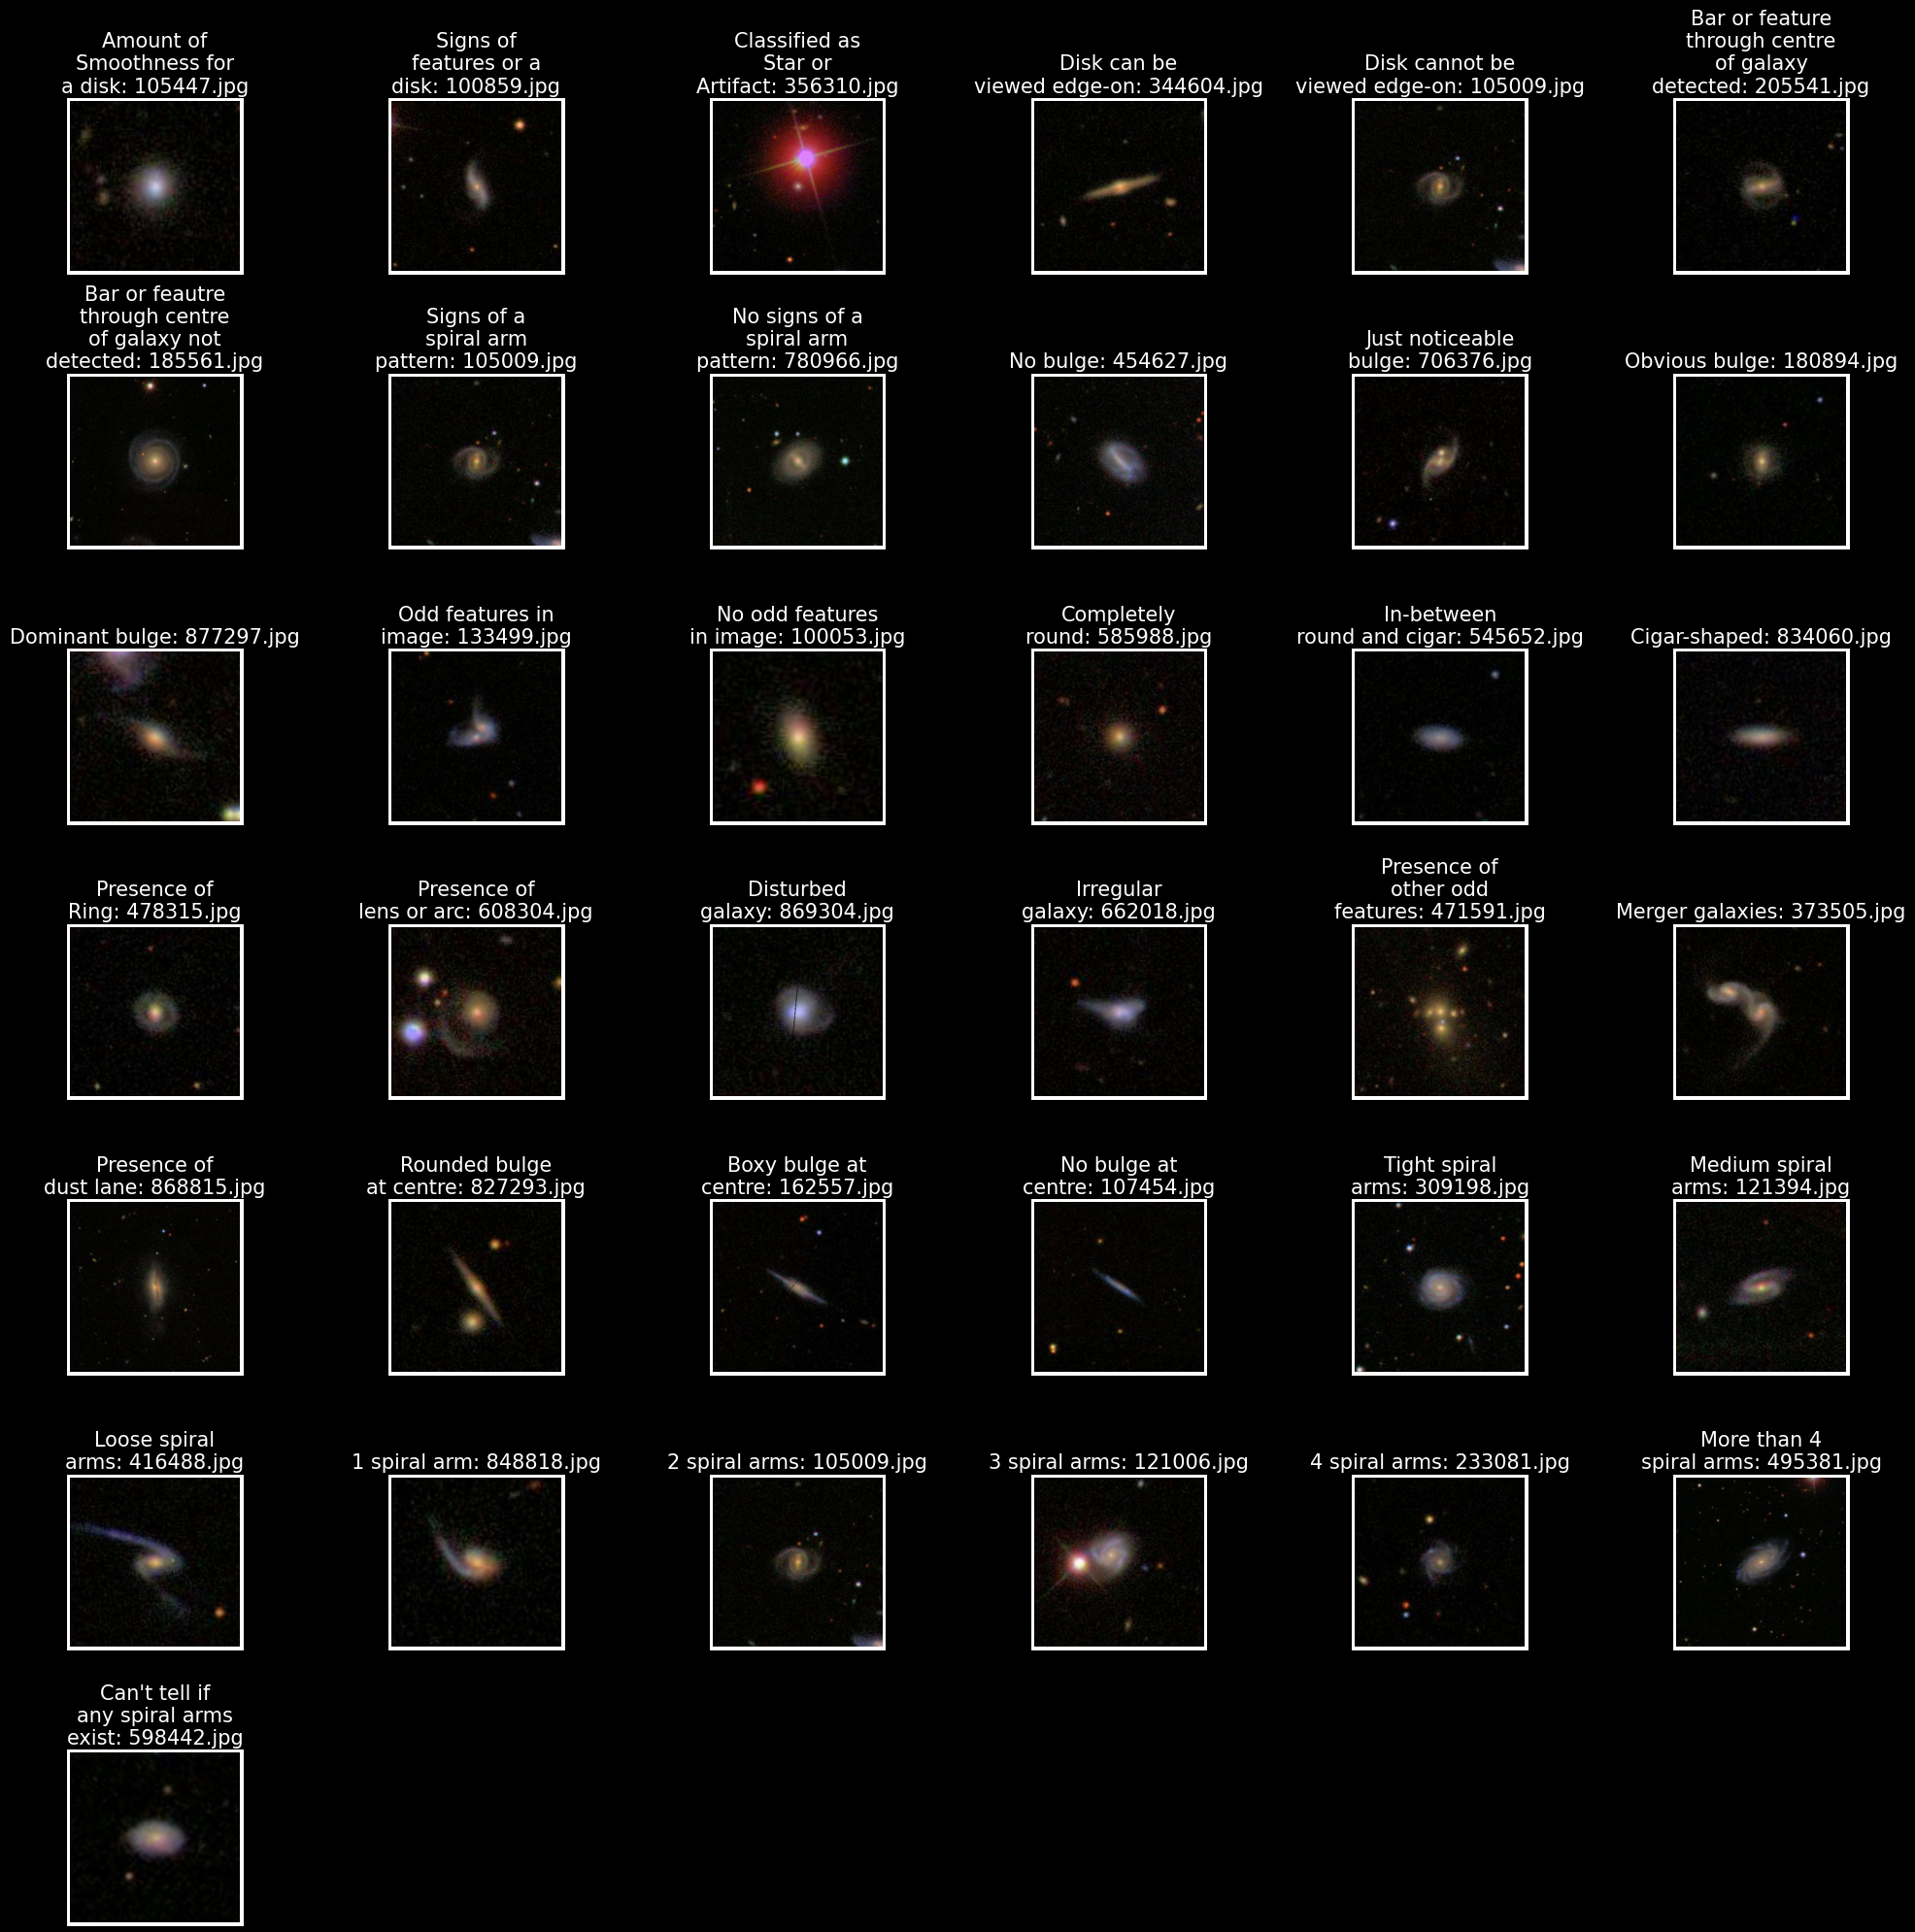

In [49]:
rows, cols = 7, 6

# Make a new figure and define dark themed style
figure = plt.figure(figsize=(20, 20))  # Increased figure size for larger images
plt.style.use('dark_background')

for i in range(1, len(maxxed_df)):
    ax = figure.add_subplot(rows, cols, i)
    filename = f"{maxxed_df['GalaxyID'].iloc[i]}.jpg"
    img = plt.imread(os.path.join(root, filename))
    plt.imshow(img)
    plt.title(f"{wrap_title(classification_names[i], width=15)}: {filename}", fontsize=15)
    plt.axis('off')
    add_subplot_border(ax, width=2, color='white')

plt.tight_layout()
plt.show()

**Based on these images, which labels do you think will be easy to classify (i.e., which are visually obvious)? Which are subtle and more likely to cause problems?**

# Question 8

In [28]:
print(type(training_classifications_df.iloc[:, 1].values))

<class 'numpy.ndarray'>


In [29]:
cor_mat = np.ndarray((num_labels - 1, num_labels - 1))

for a in range(1, num_labels):
    for b in range(1, num_labels):
        i = training_classifications_df.iloc[:, a].values
        j = training_classifications_df.iloc[:, b].values
        i_mean = np.mean(i)
        j_mean = np.mean(j)
        i_mean_squared = np.mean(np.square(i))
        j_mean_squared = np.mean(np.square(j))
        i_j_mean = np.mean(i * j)
        i_var = i_mean_squared - i_mean**2
        j_var = j_mean_squared - j_mean**2
        i_j_cov = i_j_mean - i_mean*j_mean
        correlation = i_j_cov/np.sqrt(i_var*j_var)
        cor_mat[a-1, b-1] = correlation

In [35]:
# nice way to see all values in correlation matrix in pandas DataFrame
vis_cols = [classification_names[i+1] for i in range(cor_mat.shape[1])]
vis_df = pd.DataFrame(cor_mat, columns=vis_cols, index=vis_cols)

In [50]:
vis_df

Amount of Smoothness for a disk  \
Amount of Smoothness for a disk                                            1.000000   
Signs of features or a disk                                               -0.992416   
Classified as Star or Artifact                                             0.280863   
Disk can be viewed edge-on                                                -0.324072   
Disk cannot be viewed edge-on                                             -0.746400   
Bar or feature through centre of galaxy detected                          -0.481550   
Bar or feautre through centre of galaxy not det...                        -0.564992   
Signs of a spiral arm pattern                                             -0.670888   
No signs of a spiral arm pattern                                          -0.187805   
No bulge                                                                  -0.229011   
Just noticeable bulge                                                     -0.604714   
Obvious bulge                                                             -0.442142   
Dominant bulge                                                            -0.152129   
Odd features in image                                                     -0.262177   
No odd features in image                                                   0.262177   
Completely round                                                           0.629156   
In-between round and cigar                                                 0.617418   
Cigar-shaped                                                              -0.000949   
Presence of Ring                                                          -0.253277   
Presence of lens or arc                                                    0.060418   
Disturbed galaxy                                                          -0.205088   
Irregular galaxy                                                          -0.234141   
Presence of other odd features                                             0.013934   
Merger galaxies                                                           -0.048579   
Presence of dust lane                                                     -0.079763   
Rounded bulge at centre                                                   -0.298510   
Boxy bulge at centre                                                      -0.211762   
No bulge at centre                                                        -0.200730   
Tight spiral arms                                                         -0.508271   
Medium spiral arms                                                        -0.568344   
Loose spiral arms                                                         -0.384315   
1 spiral arm                                                              -0.223538   
2 spiral arms                                                             -0.518724   
3 spiral arms                                                             -0.308240   
4 spiral arms                                                             -0.234735   
More than 4 spiral arms                                                   -0.166207   
Can't tell if any spiral arms exist                                       -0.404101   

                                                    Signs of features or a disk  \
Amount of Smoothness for a disk                                       -0.992416   
Signs of features or a disk                                            1.000000   
Classified as Star or Artifact                                        -0.396710   
Disk can be viewed edge-on                                             0.332616   
Disk cannot be viewed edge-on                                          0.747833   
Bar or feature through centre of galaxy detected                       0.481963   
Bar or feautre through centre of galaxy not det...                     0.566443   
Signs of a spiral arm pattern                                          0.671806  

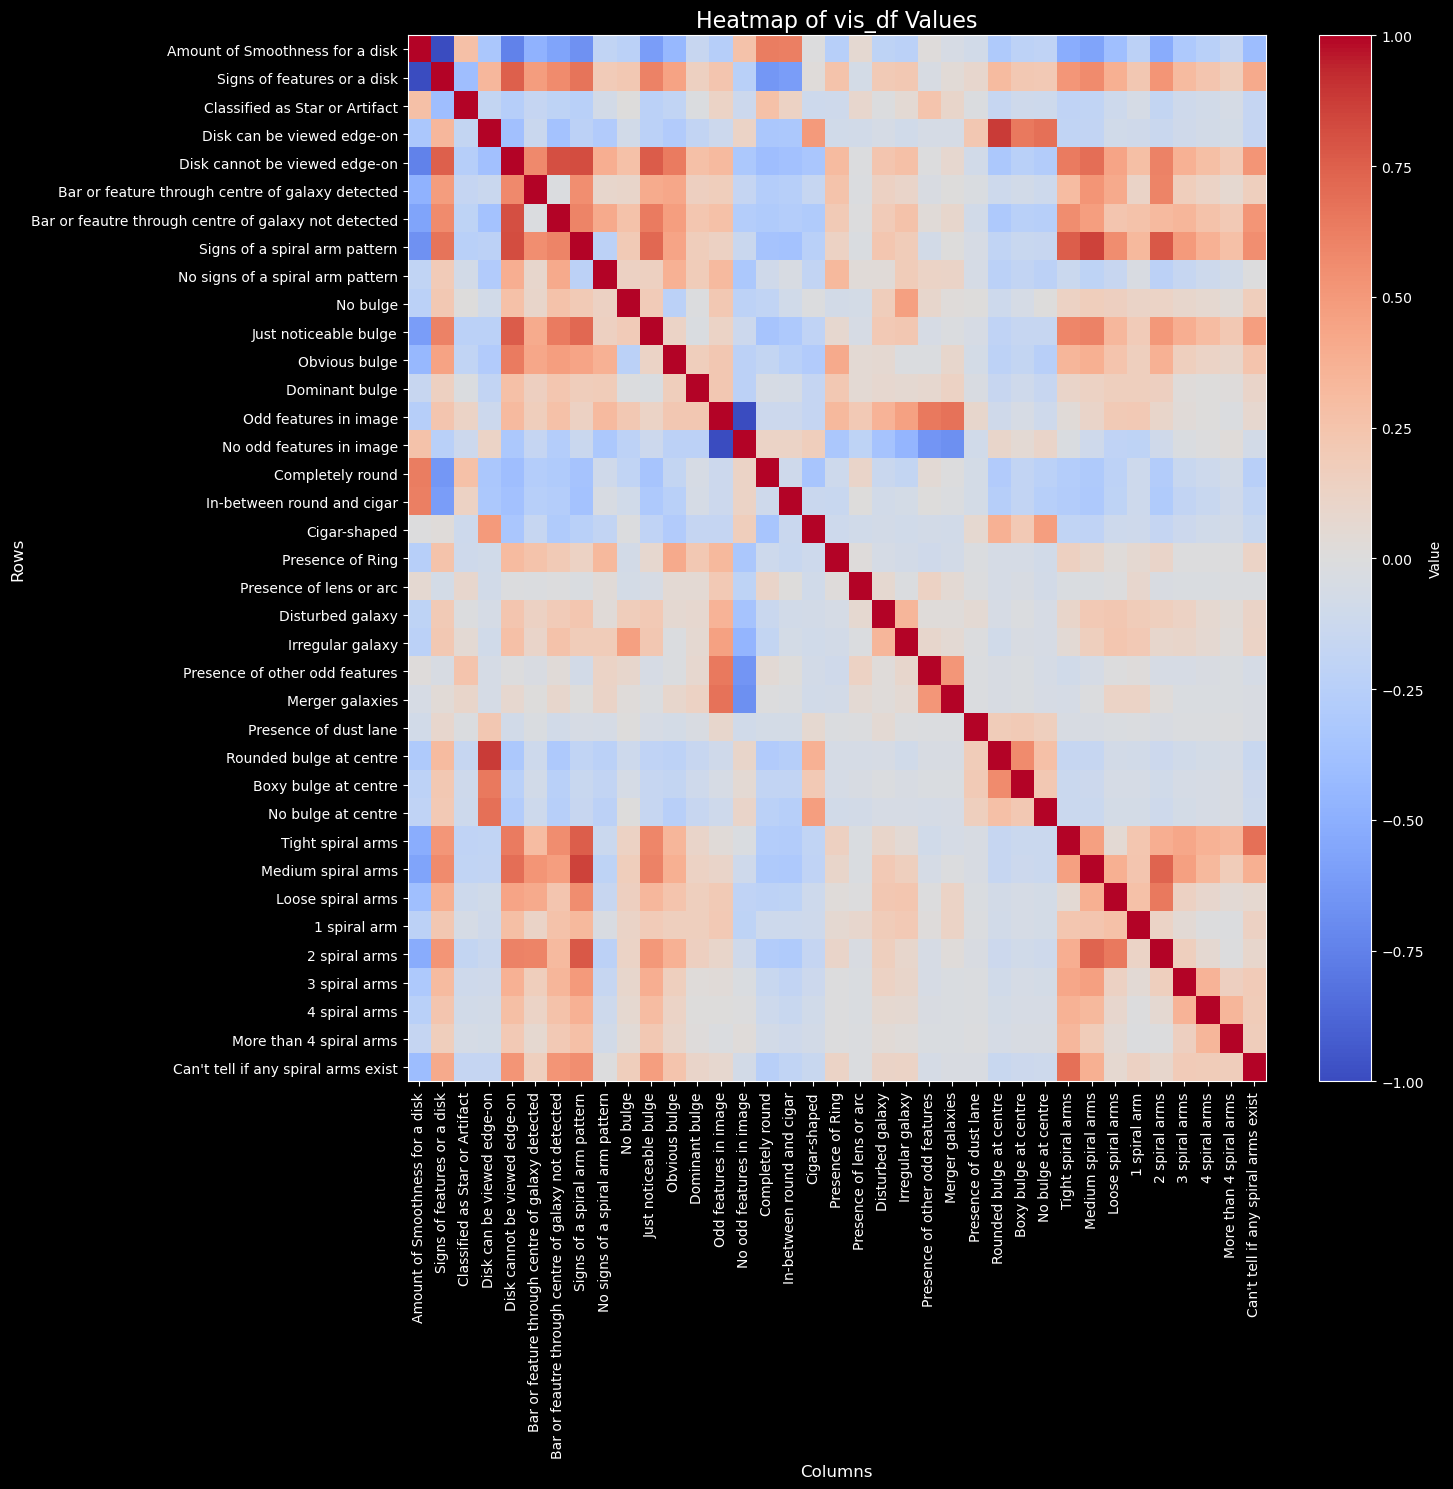

In [40]:
# Create a heatmap using Matplotlib
plt.figure(figsize=(15, 15))
plt.imshow(vis_df.values, cmap='coolwarm', aspect='auto')

# Add color bar
plt.colorbar(label='Value')

# Set ticks and labels
plt.xticks(ticks=np.arange(len(vis_df.columns)), labels=vis_df.columns, rotation=90)
plt.yticks(ticks=np.arange(len(vis_df.index)), labels=vis_df.index)

"""
# Add text annotations
for i in range(len(vis_df.index)):
    for j in range(len(vis_df.columns)):
        plt.text(j, i, f'{vis_df.iloc[i, j]:.1f}', ha='center', va='center', color='black')
"""

# Add title
plt.title("Heatmap of vis_df Values", fontsize=16)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Rows", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

# Question 9

We are going to build a model to predict classifications (labels) based on images. To train the model, we will have to repeatedly compare predictions for each image in the training set to its known labels. What is the minimum amount of memory it would take (within a factor of ∼ 2) to load each image in the training set into memory? Don’t worry (yet) about the memory required to store the model. Hint: You can estimate this by thinking about how many pixels are in the total set of images.

<span style="color: red;">
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!
    **DO THISSSSS**
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!
</span>


# Question 10

In [52]:
def downsize_image(image_path, resize_size=80):
    with Image.open(image_path) as img:
        original_width, original_height = img.size
        new_width = int(original_width / (resize_size ** 0.5))
        new_height = int(original_height / (resize_size ** 0.5))
        left = (original_width - new_width) // 2
        top = (original_height - new_height) // 2
        right = left + new_width
        bottom = top + new_height
        cropped = img.crop((left, top, right, bottom))
        downsized_image = cropped.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return np.array(downsized_image)

# Function to split list into chunks
def split_into_batches(lst, n):
    avg = len(lst) // n
    remainder = len(lst) % n
    batches = []
    start = 0
    for i in range(n):
        end = start + avg + (1 if i < remainder else 0)
        batches.append(lst[start:end])
        start = end
    return batches

In [53]:
plot_example_full = [plt.imread(os.path.join(root, f"{training_classifications_df['GalaxyID'].iloc[i]}.jpg")) for i in range(3)]
plot_example_downsized = [downsize_image(os.path.join(root, f"{training_classifications_df['GalaxyID'].iloc[i]}.jpg"), resize_size=5) for i in range(3)]

In [54]:
print(len(plot_example_full))
print(len(plot_example_downsized))

3
3


Original Image Dimensions:  (424, 424, 3)
Downsized Image Dimensions:  (189, 189, 3)


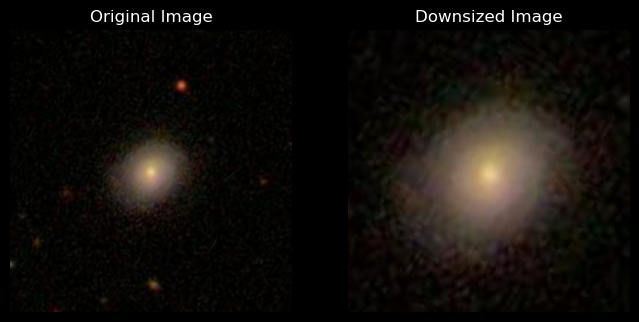

Original Image Dimensions:  (424, 424, 3)
Downsized Image Dimensions:  (189, 189, 3)


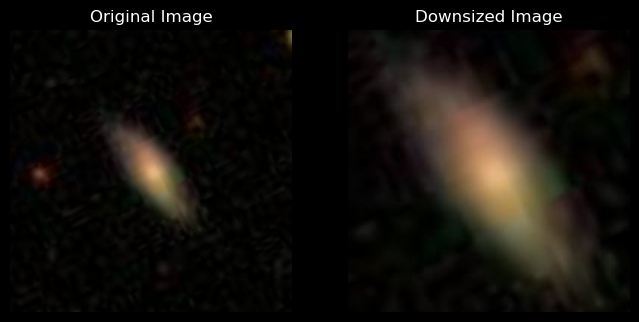

Original Image Dimensions:  (424, 424, 3)
Downsized Image Dimensions:  (189, 189, 3)


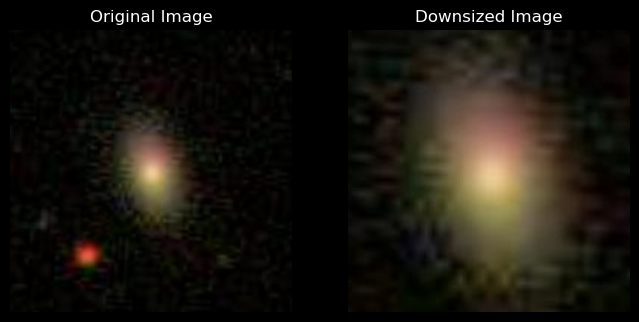

In [55]:
# Plot a few images before and after downsizing
for i in range(len(plot_example_full)):
    original_image = plot_example_full[i]
    downsized_image = plot_example_downsized[i]
    
    print("Original Image Dimensions: ", original_image.shape)
    print("Downsized Image Dimensions: ", downsized_image.shape)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(downsized_image)
    axs[1].set_title('Downsized Image')
    axs[1].axis('off')
    
    plt.show()
    
# delete to save memory
del plot_example_full
del plot_example_downsized

# Question 11

In [56]:
# Data generator function
def data_generator(batch_files, batch_size):
    current_index = 0
    labels_array = training_classifications_df.iloc[:, 1:].values
    
    for batch in batch_files:
        images = np.array(load(batch))
        
        # images is a numpy array of shape (height, width, channels)
        num_images = len(images)
        
        # Normalize images
        images = images.astype('float32') / 255.0
        
        # Get labels for these images
        batch_labels = labels_array[current_index:current_index + num_images]
        current_index += num_images
        
        # Convert images and labels to tensors
        images = torch.tensor(images, dtype=torch.float32)
        labels = torch.tensor(batch_labels, dtype=torch.float32)
        
        # Permute images to (batch_size, channels, height, width)
        images = images.permute(0, 3, 1, 2)
        
        # Create mini-batches
        dataset_size = len(images)
        num_batches = (dataset_size + batch_size - 1) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, dataset_size)
            batch_images = images[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]
            yield batch_images, batch_labels

# Question 12

In [57]:
train_df = training_classifications_df.sample(frac=0.8, random_state=42)
val_df = training_classifications_df.drop(train_df.index)

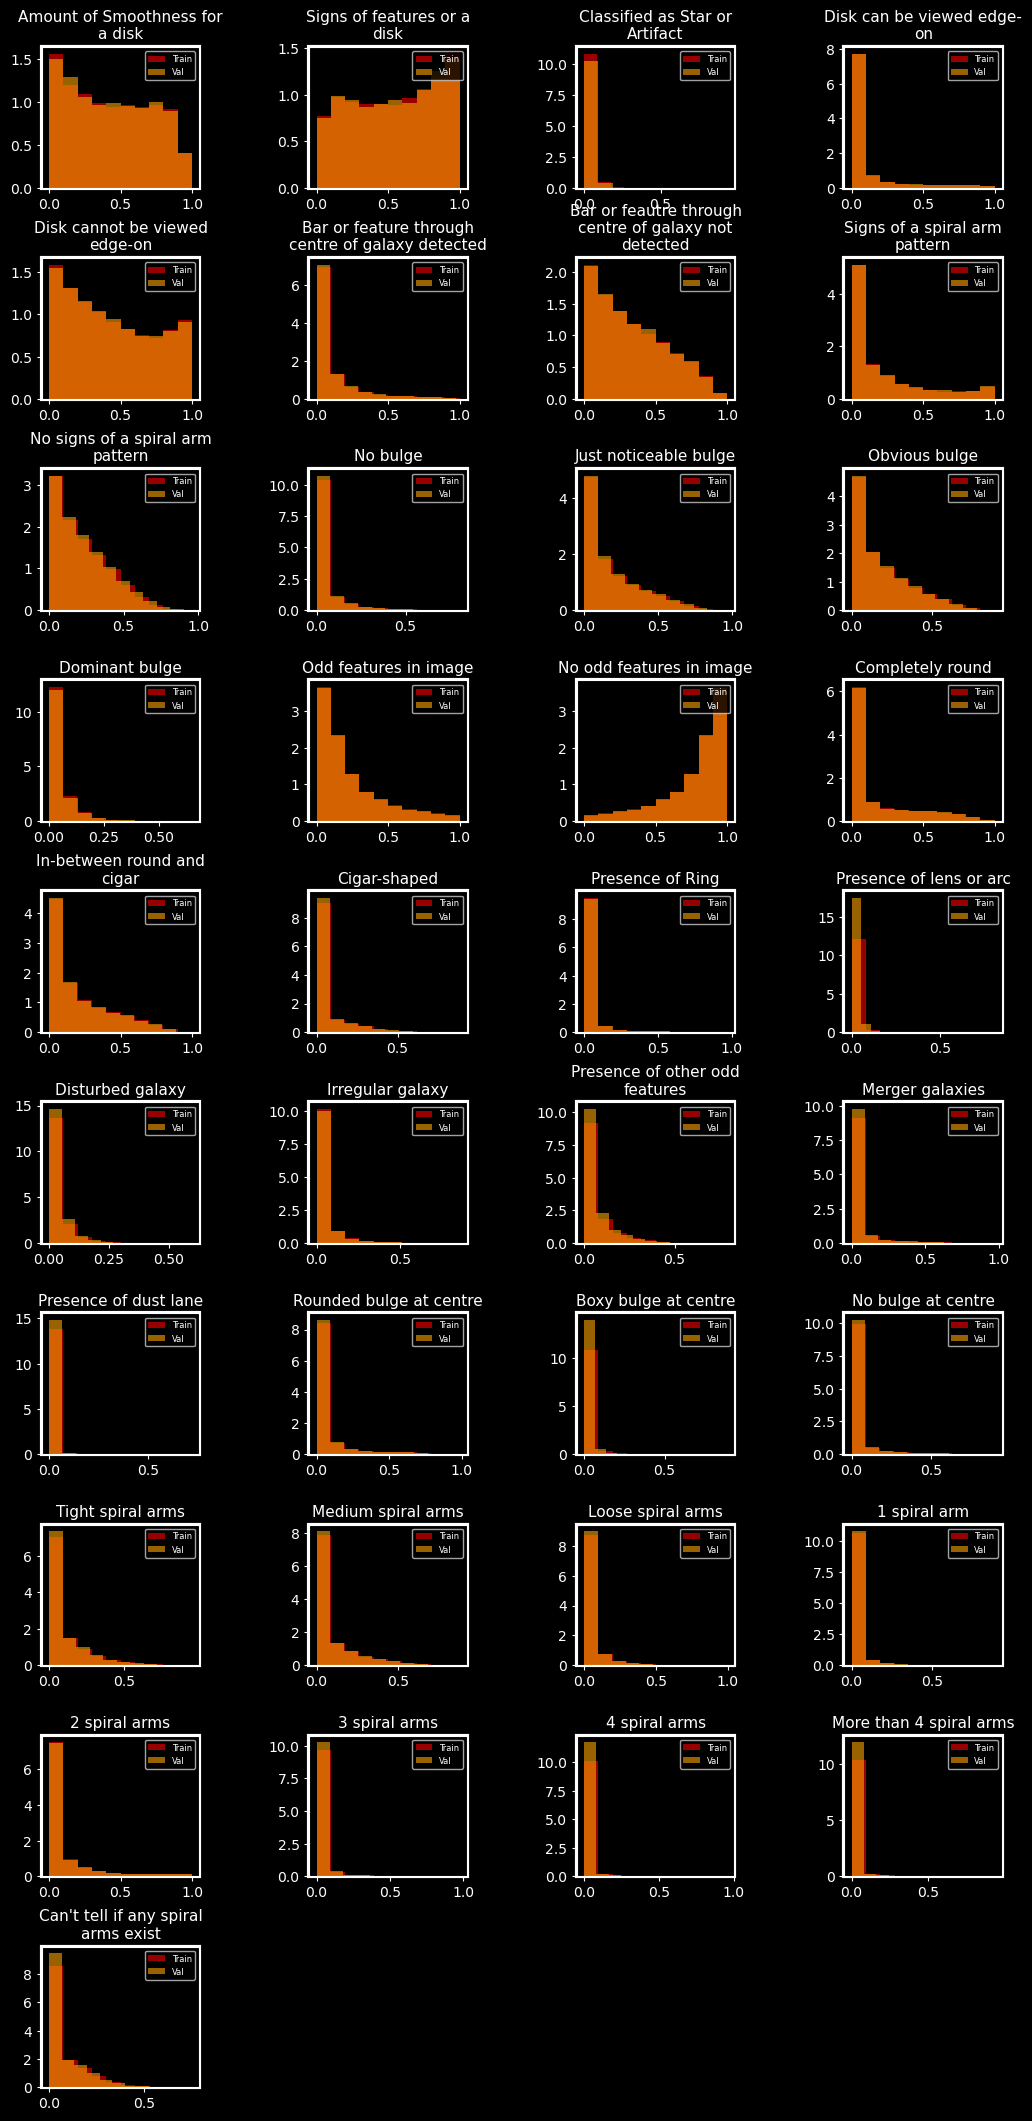

In [58]:
# Make a new figure
figure = plt.figure(figsize=(12,12))
rows, cols = 10, 4

for i in range(1, len(classification_names)):
    ax = figure.add_subplot(rows, cols, i)
    train_vals = train_df.iloc[:, i]
    val_vals = val_df.iloc[:, i]
    
    # Plot histograms for training and validation
    plt.hist(train_vals, alpha=0.6, label='Train', bins=10, color='red', density=True)
    plt.hist(val_vals, alpha=0.6, label='Val', bins=10, color='orange', density=True)
    
    # Set the title and labels
    plt.title(wrap_title(classification_names[i], width=25), fontsize=11)
    plt.legend(loc='upper right', fontsize=6)
    
    # Add subplot border
    add_subplot_border(ax, width=1, color='white')

# Adjust layout
plt.subplots_adjust(left=0.1, right=0.9, top=1.7, bottom=0.0, wspace=0.7, hspace=0.5)
plt.show()

In [26]:
num_batches = 5

In [27]:
# Get filepaths of all images
train_images = [plt.imread(os.path.join(root, f"{train_df['GalaxyID'].iloc[i]}.jpg")) for i in tqdm(range(len(train_df)), desc="Loading Training Images")]

Loading Training Images: 100%|███████████| 49262/49262 [01:12<00:00, 678.47it/s]


In [28]:
train_batches = split_into_batches(train_images, num_batches)

In [32]:
# Process in batches and save to disk
for i, batch in enumerate(train_batches):
    downsized_batch = [downsize_image((os.path.join(root, f"{train_df['GalaxyID'].iloc[i]}.jpg")), resize_size=5) for i in tqdm(range(len(batch)), desc=f"Processing Batch {i+1}")]
    save_path = f"/Volumes/2TB RAKESH/ay128-lab3-storage/downsized_batch_train_{i}.joblib"
    dump(downsized_batch, save_path)
    
    # delete to save memory
    del downsized_batch
    
# delete to save memory
del train_batches

Processing Batch 5: 100%|██████████████████| 9852/9852 [00:10<00:00, 941.82it/s]


In [33]:
del train_images

In [34]:
# Get filepaths of all images
val_images = [plt.imread(os.path.join(root, f"{val_df['GalaxyID'].iloc[i]}.jpg")) for i in tqdm(range(len(val_df)), desc="Loading Validation Images")]

Loading Validation Images: 100%|█████████| 12316/12316 [00:19<00:00, 623.61it/s]


In [35]:
val_batches = split_into_batches(val_images, num_batches)

In [36]:
# Process in batches and save to disk
for i, batch in enumerate(val_batches):
    downsized_batch = [downsize_image(os.path.join(root, f"{val_df['GalaxyID'].iloc[i]}.jpg"), resize_size=5) for img in tqdm(range(len(batch)), desc=f"Processing Batch {i+1}")]
    save_path = f"/Volumes/2TB RAKESH/ay128-lab3-storage/downsized_batch_val_{i}.joblib"
    dump(downsized_batch, save_path)
    
    # delete to save memory
    del downsized_batch
    
# delete to save memory
del val_batches

Processing Batch 5: 100%|█████████████████| 2463/2463 [00:02<00:00, 1154.79it/s]


In [37]:
del val_images

# Question 13

In [38]:
# crude guess for train labels
labels_true = np.array([np.array(train_df.iloc[:, i]) for i in range(1, len(classification_names))])
labels_predicted = np.array([np.mean(labels_true[i]) for i in range(len(labels_true))])

In [39]:
labels_predicted

array([0.4325524 , 0.54215598, 0.02529162, 0.10641663, 0.43573935,
       0.10228772, 0.33345163, 0.21567748, 0.22006187, 0.04095122,
       0.18037685, 0.17791076, 0.03650052, 0.23175702, 0.76824298,
       0.16947329, 0.20821338, 0.05486573, 0.03474187, 0.01334722,
       0.03284163, 0.04017372, 0.06449302, 0.04233573, 0.00382381,
       0.06311022, 0.01064247, 0.03266394, 0.09212405, 0.0838378 ,
       0.03971563, 0.01548132, 0.09366262, 0.01771552, 0.00778526,
       0.00724342, 0.07378934])

In [40]:
print("Mean values for the first label cross check:")
print(np.mean(labels_true[0]))
print(labels_predicted[0])

Mean values for the first label cross check:
0.4325524004912509
0.4325524004912509


In [41]:
labels_true_train = np.array([train_df.iloc[i][1:] for i in range(len(train_df))])
labels_true_val = np.array([train_df.iloc[i][1:] for i in range(len(val_df))])

In [42]:
print("Training Set:")
print(len(labels_true_train))
print(len(labels_true_train[39]))
print("")
print("Validation Set:")
print(len(labels_true_val))
print(len(labels_true_val[39]))

Training Set:
49262
37

Validation Set:
12316
37


In [43]:
# finding the RMSE

crude_rmse_train = np.sqrt(
    (1/len(train_df)*len(classification_names))
    *
    np.sum(np.square([labels_true_train[i] - labels_predicted for i in range(len(train_df))])))

crude_rmse_test = np.sqrt(
    (1/len(val_df)*len(classification_names))
    *
    np.sum(np.square([labels_true_val[i] - labels_predicted for i in range(len(val_df))])))

In [44]:
print(f"Training RMSE: {crude_rmse_train}")
print(f"Validation RMSE: {crude_rmse_test}")

Training RMSE: 6.148029322600515
Validation RMSE: 6.15305469304878


# Question 14

In [45]:
# Swish Function 
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [62]:
class GalaxyClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GalaxyClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Swish(),
        )

        self.maxpool = nn.MaxPool2d(2, 2)
        self.connected1 = nn.Linear(8192, 256)
        self.connected2 = nn.Linear(256, 128)
        self.connected3 = nn.Linear(128, num_labels-1)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        # Layer 1 forward and pooling
        x = self.layer1(x)
        x = self.maxpool(x)
        
        # Layer 2 forward and pooling
        x = self.layer2(x)
        x = self.maxpool(x)
        
        # Layer 3 forward and pooling
        x = self.layer3(x)
        x = self.maxpool(x)
        
        # Fully connected layers
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.connected1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.connected2(x), dim=-1)
        x = self.dropout(x)
        x = torch.sigmoid(self.connected3(x))
        return x

In [63]:
model = GalaxyClassifier(num_labels=num_labels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

In [64]:
train_batch_files = [f"/Volumes/2TB RAKESH/ay128-lab3-storage/downsized_batch_train_{i}.joblib" for i in range(num_batches)]
val_batch_files = [f"/Volumes/2TB RAKESH/ay128-lab3-storage/downsized_batch_val_{i}.joblib" for i in range(num_batches)]

In [65]:
num_epochs = 20
batch_size = 128
train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    
    # Training the model
    # set the model to train mode
    model.train()
    
    training_loss = 0.0
    training_samples = 0
    
    # get the data to train in batch
    data_gen = data_generator(train_batch_files, batch_size)
    for batch_images, batch_labels in data_gen:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_images)
        
        # Compute loss
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and samples
        training_loss += loss.item()
        training_samples += 1
        
    avg_training_loss = training_loss / training_samples
    train_loss.append(avg_training_loss)
    
    # Validation
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    validation_samples = 0
    with torch.no_grad():
        val_data_gen = data_generator(val_batch_files, batch_size)
        for val_images, val_labels in val_data_gen:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Forward pass
            outputs = model(val_images)
            
            # Compute loss
            loss = criterion(outputs, val_labels)
            
            # Accumulate loss and samples
            validation_loss += loss.item()
            validation_samples += 1
    
    avg_validation_loss = validation_loss / validation_samples
    val_loss.append(avg_validation_loss)
    
    scheduler.step(avg_validation_loss)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}')

# Save the trained model
cnn_save_path = 'galaxy_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_hist': train_loss,
    'val_loss_hist': val_loss
}, cnn_save_path)

print(f"Model is saved at {cnn_save_path}!")

  5%|██                                       | 1/20 [04:03<1:17:03, 243.36s/it]

Epoch [1/20], Training Loss: 0.0598, Validation Loss: 0.0587


  5%|██                                       | 1/20 [05:08<1:37:33, 308.05s/it]


KeyboardInterrupt: 

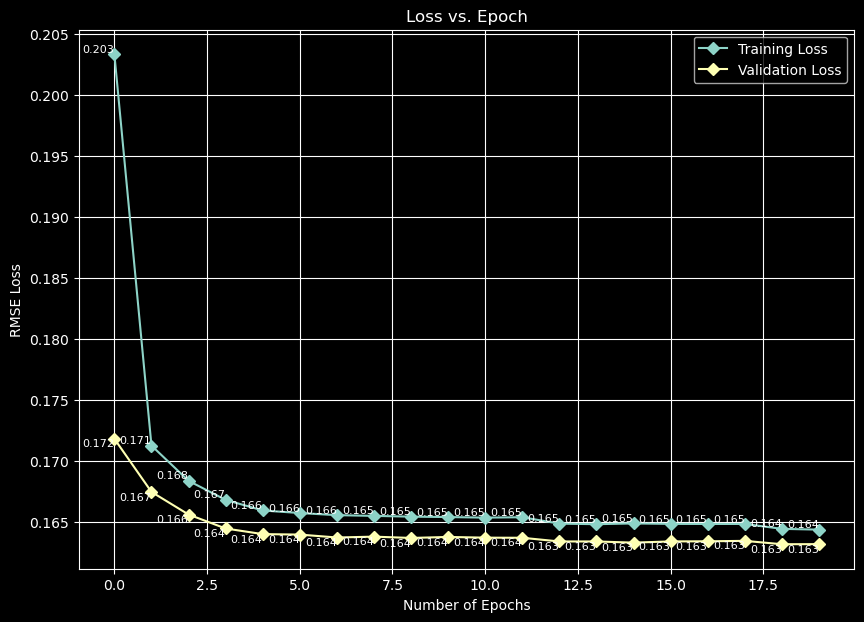

In [103]:
# Plot
plt.figure(figsize=(10, 7))
plt.plot(range(num_epochs), np.sqrt(np.array(train_loss)), label="Training Loss", marker='D')
plt.plot(range(num_epochs), np.sqrt(np.array(val_loss)), label="Validation Loss", marker='D')

# Add annotations for Training Loss
for i, loss in enumerate(np.sqrt(np.array(train_loss))):
    plt.text(i, loss, f"{loss:.3f}", fontsize=8, ha='right', va='bottom')

# Add annotations for Validation Loss
for i, loss in enumerate(np.sqrt(np.array(val_loss))):
    plt.text(i, loss, f"{loss:.3f}", fontsize=8, ha='right', va='top')

# Labels, title, legend, and grid
plt.xlabel("Number of Epochs")
plt.ylabel("RMSE Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()


# Question 15

How many total trainable parameters does your model have? In PyTorch, you can count the number of elements in a layer using p.numel(), where p in an element of model.parameters. You can tell whether a parameter is trainable using p.requires_grad(). Does the number of free parameters make you nervous? Explain. Compare it to the number of pixels in your compressed training set.

In [104]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

Total trainable parameters: 2228773


# Question 16

In building your networks, you may have struggled to decide on the right network architecture. How many layers? What kind of pooling? How much dropout? You might also have found that as the size of the network increases, it gets pretty tedious to set up the layers by hand and keep track of their dimension when they meet.

One solution to both of these issues is to use a network architecture that has already been proven to work well for image classification. Check out He et al. 2015, which describes ResNets, one of the most popular networks introduced in computer vision in the last several years. Describe in a few sentences what ResNets are. How are they different from just stacking more and more layers on a CNN?

# Question 17

In [137]:
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features

/Users/rakeshmehta/anaconda3/envs/astrods/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rakeshmehta/anaconda3/envs/astrods/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [138]:
resnet18.fc = nn.Linear(num_ftrs, num_labels-1)
resnet18 = resnet18.to(device)

for epoch in tqdm(range(num_epochs)):
    resnet18.train()  # Set model to training mode
    training_loss = 0.0
    training_samples = 0
    # Training data generator
    train_data_gen = data_generator(train_batch_files, batch_size)
    for batch_images, batch_labels in train_data_gen:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet18(batch_images)

        # Compute loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and samples
        training_loss += loss.item()
        training_samples += 1

    avg_training_loss = training_loss / training_samples

    # Validation
    resnet18.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    validation_samples = 0
    with torch.no_grad():
        val_data_gen = data_generator(val_batch_files, batch_size)
        for val_images, val_labels in val_data_gen:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            outputs = resnet18(val_images)

            # Compute loss
            loss = criterion(outputs, val_labels)

            # Accumulate loss and samples
            validation_loss += loss.item()
            validation_samples += 1

    avg_validation_loss = validation_loss / validation_samples

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'galaxy_classifier_resnet18.pth')

  5%|██▏                                        | 1/20 [04:42<1:29:31, 282.73s/it]

Epoch [1/20], Training Loss: 0.6257, Validation Loss: 0.6349


  5%|██▏                                        | 1/20 [05:37<1:47:00, 337.93s/it]


KeyboardInterrupt: 